# GW Legacy Object and Target Identification

Using the DR8 Legacy Survey, identify all objects within the 90% credible interval of a GW alert angular reconstruction.

Then compare the selected objects against the bright targets selected from DR8.

In [2]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique
from scipy.stats import norm

try:
    from astropy.cosmology import Planck18_arXiv_v2
    cosmo = Planck18_arXiv_v2
except ImportError as e:
    print(e)
    from astropy.cosmology import Planck15
    cosmo = Planck15

import logging
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_mollmap, plot_cartmap

from desitarget import io, cuts
from desitarget.targetmask import desi_mask, bgs_mask

mpl.rc('font', size=12)

## DR8 Access Functions

Use the `desitarget.io` interface to access the DR8 sweep files and the corresponding photo-z catalogs. For more information see the [Legacy Survey DR8 File Directory](http://legacysurvey.org/dr8/files/) and the [photo-z catalog](https://arxiv.org/abs/2001.06018) developed for DR8 by Rongpu Zhou et al.

In [3]:
def get_sweepfiles(sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0', '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']):
    """Given a search folder or folders, return a list of sweep files.
    
    For details on file locations see For details see http://legacysurvey.org/dr8/files/.
    
    Parameters
    ----------
    sweepfolders : str or list
        A folder or list of folders to search for sweep files.
    
    Returns
    -------
    sweeplist : list
        List of sweep files.
    """
    sweeplist = None
    
    if np.isscalar(sweepfolders):
        sweeplist = io.list_sweepfiles(sweepfolders)
    else:
        for fldr in sweepfolders:
            if sweeplist is None:
                sweeplist = io.list_sweepfiles(fldr)
            else:
                sweeplist += io.list_sweepfiles(fldr)
                
    return sweeplist

def get_objects_in_gw_contour(sweepfolders, lvc_hp_file, level=0.9):
    """Return a list of Legacy Survey objects inside a GW contour.
    
    Parameters
    ----------
    sweepfolders : str or list
        A folder or list of folders to search for sweep files.
    lvc_hp_file : str
        HEALPix file with LVC event reconstruction.
    level : float
        Contour level, in [0..1].
        
    Returns
    -------
    objtab : astropy.Table
        Table of Legacy Survey objects inside GW contour.
    """
    # Get luminosity distance to GW marginalized over all angles.
    hdus = fits.open(lvc_hp_file)
    header = hdus[1].header
    distmean = header['DISTMEAN']
    diststd = header['DISTSTD']
    
    # Get contours for the GW skymap. For further details, see
    # https://arxiv.org/abs/1605.04242
    gwmap, distmu, distsigma, distnorm = hp.read_map(lvc_hp_file, field=[0,1,2,3])
    gw_maxprob = np.max(gwmap)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)
    thresh = compute_quantiles([level], gwmap)[0]
    logging.info('{:g}% confidence level of GW map {:s} = {:g}'.format(100*level, lvc_hp_file, thresh))
    
    # Get list of pixels above threshold defined by level.
    pixels = hp.ring2nest(nside, np.arange(npix))
    pixids = pixels[gwmap > thresh]
    
    # Loop through all sweeps, see if pixel indices match with any bricks.
    sweepfiles = get_sweepfiles(sweepfolders)
    gwsweeps = []
    for sf in sweepfiles:
        ramin, ramax, decmin, decmax = io.decode_sweep_name(sf)
        ra = [ramin, ramax, ramax, ramin]
        dec = [decmin, decmin, decmax, decmax]
        box = hp.ang2vec(ra, dec, lonlat=True)
        boxpix = hp.query_polygon(nside, box, nest=True)
        
        if not set(boxpix).isdisjoint(pixids):
            gwsweeps.append(sf)

    # Grab photo-z data and read everything into a table.
    gwspeeps, photozs = get_sweep_photo_z(gwsweeps)
    
    pixarea_deg2 = hp.nside2pixarea(nside, degrees=True)
    
    objtab = None
    for sf, pz in zip(gwsweeps, photozs):
        print(sf)
        data = Table(io.read_tractor(sf, columns=['BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
                                                  'FLUX_G', 'FLUX_R', 'FLUX_Z',
                                                  'NOBS_G', 'NOBS_R', 'NOBS_Z',
                                                  'FRACIN_G', 'FRACIN_R', 'FRACIN_Z',
                                                  'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
                                                  'PMRA', 'PMDEC', 'MASKBITS'
                                                  ]))
        data_pz = Table.read(pz)
        
        # Cut pixels not in 90% region.
        brickpix = hp.ang2pix(nside, data['RA'], data['DEC'], lonlat=True, nest=True)
        brickringpix = hp.nest2ring(nside, brickpix)
        
#         gw_prob = gwmap[hp.nest2ring(nside, brickpix)] / gw_maxprob
        dp_dA_deg2 = gwmap[brickringpix] / pixarea_deg2
        dist_mu = distmu[brickringpix]
        dist_sigma = distsigma[brickringpix]
        
        data.add_column(Column(name='angprob', data=dp_dA_deg2, unit='1/degree**2'))
        data.add_column(Column(name='distmu', data=dist_mu, unit='Mpc'))
        data.add_column(Column(name='distsigma', data=dist_sigma, unit='Mpc'))
        
        in_gw = np.isin(brickpix, pixids)
#         nonneg_z = data_pz['z_phot_mean'] >= 0
#         select = np.logical_and(in_gw, nonneg_z)
        select = in_gw
        
        if objtab is None:
            objtab = hstack([data[select], data_pz[select]])
        else:
            objtab = vstack([objtab, hstack([data[select], data_pz[select]])])
            
    # Compute luminosity distance given mean photo-z.
    nonzero_prob = objtab['angprob'] > 0
    logging.info('Computing luminosity distances for {:d} objects.'.format(np.sum(nonzero_prob)))
    
    d_L = np.zeros(len(objtab))
    nonneg_z = objtab['z_phot_mean'] >= 0
    d_L[nonzero_prob & nonneg_z] = cosmo.luminosity_distance(objtab[nonzero_prob & nonneg_z]['z_phot_mean']).to('Mpc').value
    objtab.add_column(Column(name='D_L', data=d_L, unit='Mpc'))
    
    return objtab
    
def get_sweep_photo_z(sweepfiles):
    """Return Legacy Survey photo-z files.
    
    Parameters
    ----------
    sweepfolders : str or list
        A folder or list of folders to search for sweep files.
    
    Returns
    -------
    sweeplist : list
        List of sweep files.
    photozlist : list
        List of photo-z files corresponding to sweep files.
    """
    # Search for matching photo-z files.
    sweeplist = sweepfiles
    photozlist = None
    logging.warning('Photo-z search hardcoded for DR8 v8.0.')

    for sweep in sweeplist:
        sweep_pz = sweep.replace('8.0', '8.0-photo-z').replace('.fits', '-pz.fits')

        # If photo-z file not found, remove corresponding sweep file from list.
        if os.path.exists(sweep_pz):
            if photozlist is None:
                photozlist = [sweep_pz]
            else:
                photozlist.append(sweep_pz)
        else:
            sweeplist.remove(sweep)
            
    return sweeplist, photozlist

### Access DR8 Catalog Data

Grab DR8 objects inside the 90% contour of a GW alert.

In [4]:
gwfile = 'GW190412_skymap.fits.gz'

In [5]:
logging.basicConfig(level=logging.INFO)

sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0',
              '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']

objcat = get_objects_in_gw_contour(sweepfolders, gwfile)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-220p030-230p035.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-210p035-220p040.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-220p035-230p040.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/sweep-210p030-220p035.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-220p030-230p035.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-220p035-230p040.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-210p030-220p035.fits


INFO:root:Computing luminosity distances for 693283 objects.


In [6]:
objcat

BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MASKBITS,PMRA,PMDEC,angprob,distmu,distsigma,z_phot_mean,z_phot_median,z_phot_std,z_phot_l68,z_phot_u68,z_phot_l95,z_phot_u95,z_spec,survey,training,D_L
,,,,,,,,,,,,,,,,,,,,,1 / deg2,Mpc,Mpc,,,,,,,,,,,Mpc
int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,int16,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes10,bool,float64
520774,2200p350,120,REX,220.00547218267306,34.87891652956301,0.299475,0.3475637,0.83379847,0.96174586,0.98155975,0.9778689,3,3,3,0.13609639,0.15795028,0.3789196,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,1.1245359,1.1384652,0.17316614,0.97721624,1.2674745,0.826835,1.3724085,-99.0,,False,7848.378821996121
520774,2200p350,188,REX,220.00515923398555,34.88593849092773,0.033515215,0.54722583,2.6155856,0.98841846,0.9942345,0.9953947,3,3,3,0.01958084,0.31970978,1.5281228,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,0.87700623,0.88085735,0.088218,0.7987393,0.95361805,0.715463,1.0721499,-99.0,,False,5778.502622624202
520774,2200p350,189,REX,220.00416142052927,34.8846666769044,0.0319439,0.44346398,1.9286726,0.9944537,0.99713534,0.9898696,3,3,3,0.02117036,0.29389936,1.2781999,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,0.87286633,0.87083095,0.08737178,0.7987393,0.9549581,0.7334877,1.039759,-99.0,,False,5745.003823197734
520774,2200p350,206,PSF,220.0103423627707,34.88651358031483,0.20157515,0.3935176,6.265988,0.99550956,0.99735004,0.9954478,3,3,3,0.15698245,0.30646315,4.8798184,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,0.9408334,0.9336581,0.16721074,0.782292,1.1056981,0.61344045,1.283881,-99.0,,False,6299.9417680343995
520774,2200p350,207,PSF,220.00964713728507,34.88848907289682,3.7671883,9.913333,16.337103,0.998035,0.9990283,0.9985277,3,3,3,2.9221084,7.6895103,12.672259,0,-8.848959,-8.331199,0.018297946930730846,691.5288518785131,101.21136733610648,0.10149719,0.08302191,0.064052515,0.044936538,0.15850343,0.026605576,0.25802246,-99.0,,False,483.42483881661315
520774,2200p350,264,REX,220.00521725303187,34.88895111662508,0.10648412,0.46953154,1.4247956,0.97379076,0.98419917,0.982465,3,3,3,0.046255935,0.20396112,0.618921,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,1.003098,0.98994505,0.19245338,0.8410225,1.1594908,0.67833716,1.31891,-99.0,,False,6817.19690355357
520774,2200p350,286,REX,220.00296857153563,34.891072400832094,0.10847499,0.25110278,0.73652583,0.9699288,0.9827943,0.9792851,3,3,3,0.07403053,0.17136921,0.50265414,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,0.97122484,0.9861206,0.18175645,0.7910156,1.1604509,0.58081245,1.2765336,-99.0,,False,6551.391512600344
520774,2200p350,303,REX,220.0072619352263,34.892946380344206,0.24502546,0.50076944,0.56281024,0.97856635,0.9888106,0.9855086,3,3,3,0.16633035,0.33993673,0.38205183,0,0.0,0.0,0.018297946930730846,691.5288518785131,101.21136733610648,0.6804028,0.63718843,0.29804215,0.37182888,1.0439553,0.23886831,1.2687966,-99.0,,False,4235.524395355795


### Cuts on Luminosity Distance

Super-basic distance cut: for each DR8 object in the 90% angular credible interval, calculate the residual between its estimated mean luminosity distance computed from the DR8 photo-z catalog, $D_{L}$ and the mean marginal luminosity distance in the HEALPixel of the GW reconstruction, $d_L$:

$$
\begin{equation}
\Delta_i = \frac{D_{L,i} - d_{L,i}}{\sigma_{d_i}}
\end{equation}
$$

The residual ignores uncertainties in $d_L$ (which are non-Gaussian) and uses the Gaussian errors in $D_L$.

Here we select all objects with $|\Delta_i|\leq1.645$, defining the central interval 90% of the per-pixel luminosity distance. 

In [7]:
Delta_L = (objcat['D_L'] - objcat['distmu']) / objcat['distsigma']
rescut = np.abs(Delta_L) < 1.645
print('{} / {} objects ({:.2g}%) in 90% CI of GW luminosity distance.'.format(np.sum(rescut), len(objcat), 1e2*np.sum(rescut)/len(objcat)))

6355 / 693283 objects (0.92%) in 90% CI of GW luminosity distance.


#### Photo-z Distribution after Cut

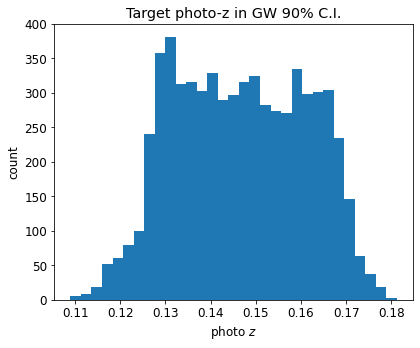

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.hist(objcat['z_phot_mean'][rescut], bins=31)
ax.set(xlabel='photo $z$',
       ylabel='count',
       title='Target photo-z in GW 90% C.I.');

### Color-color diagrams

#### Including PSF Morph Types

In [9]:
nonneg_mag = (objcat['FLUX_G'] > 0) & (objcat['FLUX_R'] > 0) & (objcat['FLUX_Z'] > 0)
select = rescut & nonneg_mag
g, r, z = [22.5 - 2.5*np.log10(objcat[select]['FLUX_{}'.format(_)]) for _ in 'GRZ']

# Cut on z<21 since dimmer galaxies have poor photo-z.
# See description at https://www.legacysurvey.org/dr8/files/#photometric-redshift-files-8-0-photo-z-sweep-brickmin-brickmax-pz-fits
#
# Also cut on r<21.
colcut = (z < 21) & (r < 21)

print('{} / {} objects ({:.2g}%) pass mag cuts.'.format(np.sum(colcut), np.sum(rescut), 1e2*np.sum(colcut)/np.sum(rescut)))

6214 / 6355 objects (98%) pass mag cuts.


  49 of type COMP
 726 of type DEV
   0 of type DUP
1349 of type EXP
3649 of type PSF
 568 of type REX


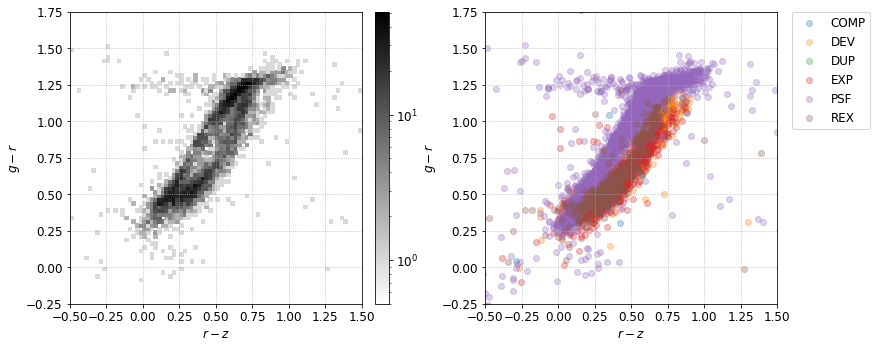

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'width_ratios':[1.1,1]})

ax = axes[0]
h = ax.hist2d(r[colcut] - z[colcut], g[colcut] - r[colcut],
              bins=[np.linspace(-0.5,1.5,81), np.linspace(-0.25,1.75,81)],
              norm=mpl.colors.LogNorm(), vmin=0.5,
              cmap='gray_r')
ax.set(xlim=(-0.5, 1.5), xlabel='$r-z$',
       ylim=(-0.25, 1.75), ylabel='$g-r$',
       aspect='equal')
ax.grid(ls=':')
fig.colorbar(h[3], ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
for _type in np.unique(objcat['TYPE']):
    select = rescut & nonneg_mag & (objcat['TYPE']==_type)
    print('{:4d} of type {}'.format(np.sum(select), _type))
    g_, r_, z_ = [22.5 - 2.5*np.log10(objcat[select]['FLUX_{}'.format(_)]) for _ in 'GRZ']

    ax.scatter(r_-z_, g_-r_, alpha=0.3, label=_type)

ax.set(xlim=(-0.5, 1.5), xlabel='$r-z$',
       ylim=(-0.25, 1.75), ylabel='$g-r$',
       aspect='equal')
ax.grid(ls=':')

ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout();

#### Excluding PSF Morph Types

In [11]:
nonpsf = objcat['TYPE'] != 'PSF'
select = rescut & nonneg_mag & nonpsf
g, r, z = [22.5 - 2.5*np.log10(objcat[select]['FLUX_{}'.format(_)]) for _ in 'GRZ']

colcut = (z < 21) & (r < 21)

  49 of type COMP
 726 of type DEV
   0 of type DUP
1349 of type EXP
   0 of type PSF
 568 of type REX


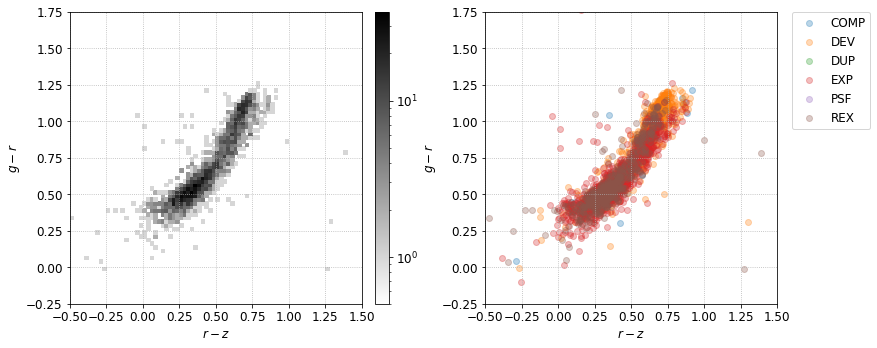

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'width_ratios':[1.1,1]})

ax = axes[0]
h = ax.hist2d(r[colcut] - z[colcut], g[colcut] - r[colcut],
              bins=[np.linspace(-0.5,1.5,81), np.linspace(-0.25,1.75,81)],
              norm=mpl.colors.LogNorm(), vmin=0.5,
              cmap='gray_r')
ax.set(xlim=(-0.5, 1.5), xlabel='$r-z$',
       ylim=(-0.25, 1.75), ylabel='$g-r$',
       aspect='equal')
ax.grid(ls=':')
fig.colorbar(h[3], ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
for _type in np.unique(objcat['TYPE']):
    select_ = rescut & nonneg_mag & nonpsf & (objcat['TYPE']==_type)
    print('{:4d} of type {}'.format(np.sum(select_), _type))
    g_, r_, z_ = [22.5 - 2.5*np.log10(objcat[select_]['FLUX_{}'.format(_)]) for _ in 'GRZ']

    ax.scatter(r_-z_, g_-r_, alpha=0.3, label=_type)

ax.set(xlim=(-0.5, 1.5), xlabel='$r-z$',
       ylim=(-0.25, 1.75), ylabel='$g-r$',
       aspect='equal')
ax.grid(ls=':')

ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout();

#### RA and Dec of Targets in 90% CI

Save imaging targets in 90% C.I. of the GW angular and distance maps in a table called `targimg90`.

In [13]:
select = rescut & nonneg_mag & nonpsf

targimg90 = objcat[select][colcut]
ra90  = targimg90['RA']
dec90 = targimg90['DEC']
len(targimg90)

2652

### Plot Contours and Targets

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 45 deg 0.00'.
  warnings.warn(
INFO:root:RA_min=215.2, RA_max=221.1, Dec_min=34.2, Dec_max=38.6


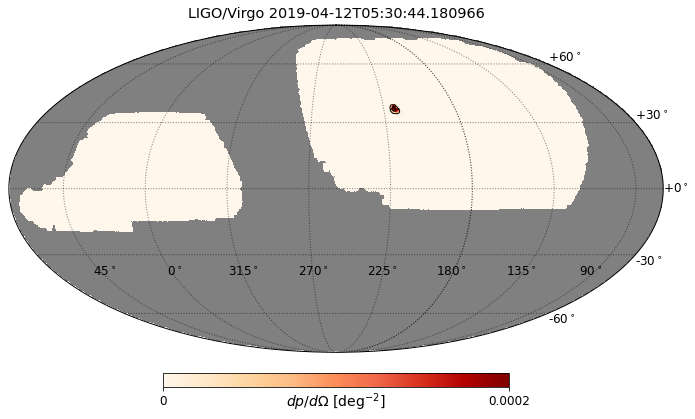

In [14]:
fig = plot_mollmap(gwfile)

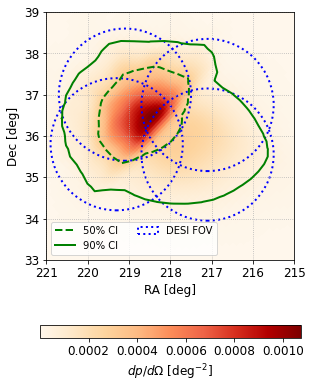

In [15]:
fig = plot_cartmap(gwfile, tile_ra=[219.1,217.1,219.3,217.1], tile_dec=[37.0,36.75,35.8,35.55], angsize=3)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

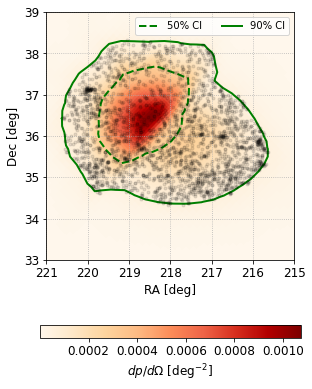

In [17]:
fig = plot_cartmap(gwfile, targ_ra=ra90, targ_dec=dec90, angsize=3)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

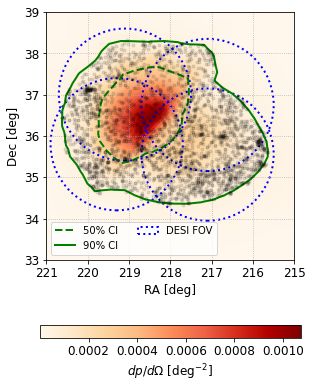

In [18]:
fig = plot_cartmap(gwfile, tile_ra=[219.1,217.1,219.3,217.1], tile_dec=[37.0,36.75,35.8,35.55],
                   targ_ra=ra90, targ_dec=dec90,
                   angsize=3)

## Compare to DESI DR8 Target List

Compare selected targets with the DESI target list constructed from DR8.

In [21]:
# Load sample of resolved DR8 target catalog using HEALPixels above threshold in the GW map.
# Get list of pixels above threshold defined by level.
gwmap = hp.read_map(gwfile)
npix = len(gwmap)
nside = hp.npix2nside(npix)
levels = [0.50, 0.90]
lev50, lev90 = compute_quantiles(levels, gwmap)

pixels = hp.ring2nest(nside, np.arange(npix))
pix90 = pixels[gwmap > lev90]

hpdirnames = ['/global/project/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright',
              '/global/project/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/dark']
readcols = ['TARGETID', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID',
            'RA','DEC','FLUX_G','FLUX_R','FLUX_Z',
            'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
            'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET']

targlist90 = None
for hpdirname in hpdirnames:
    if targlist90 is None:
        targlist90 = Table(io.read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90, columns=readcols))
    else:
        targlist90 = vstack(targlist90, Table(io.read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90, columns=readcols)))
        
targlist90.rename_column('BRICK_OBJID', 'OBJID')
targlist90 = unique(targlist90)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

In [22]:
targlist90

BRICKID,BRICKNAME,OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64
517202,2172p342,3420,217.32170704239283,34.35840678532735,12.638921,18.531113,16.345072,9.818534,14.395878,12.697653,35190939437763932,1152921504606848004,1028,0
517203,2175p342,3292,217.5175800107535,34.35568071560189,85.90801,137.87901,156.25786,66.71956,107.08229,121.35603,35190939441958108,2305843009213693952,0,768
517203,2175p342,3315,217.67716348895294,34.357030403683744,4.174772,10.211371,19.985794,1.9672549,4.811849,9.417796,35190939441958131,1152921504606846976,257,0
517203,2175p342,3416,217.50147214786998,34.363536365505034,3.4577537,10.584017,22.246555,1.637756,5.013092,10.537024,35190939441958232,1152921504606846976,257,0
517203,2175p342,3507,217.66025709201858,34.37328197517194,16.125097,55.553238,108.29026,4.0550365,13.970174,27.232143,35190939441958323,1152921504606846976,514,0
517203,2175p342,3539,217.38947442578856,34.373279599411276,9.161235,26.089565,45.344254,7.078085,20.157125,35.03354,35190939441958355,2305843009213693952,0,17
517203,2175p342,3579,217.57772038781792,34.37482991368313,7.555036,12.255058,18.409058,2.4707534,4.0078206,6.020387,35190939441958395,1152921504606846976,257,0
517204,2178p342,3006,217.698322414612,34.32746630799084,14.746882,28.900888,47.725773,6.8382215,13.401523,22.13074,35190939446152126,1152921504606846976,514,0
517204,2178p342,3376,217.69661710217235,34.348338429426946,34.036846,43.371677,44.015182,26.480774,33.7433,34.243954,35190939446152496,2305843017803628544,0,768


### Select Bright Targets

In [23]:
bgs_bright = (targlist90['BGS_TARGET'] & bgs_mask.mask('BGS_BRIGHT')) != 0
print('{:d} / {:d} = {:.1f}% are BGS bright targets'.format(np.sum(bgs_bright), len(targlist90), 1e2*np.sum(bgs_bright)/len(targlist90)))
btarglist90 = targlist90[bgs_bright]

8887 / 26190 = 33.9% are BGS bright targets


### Merge Bright Target List and Legacy Object List

In [24]:
bmerg90 = join(btarglist90, targimg90)
bmerg90

BRICKID,BRICKNAME,OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TYPE,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,MASKBITS,PMRA,PMDEC,angprob,distmu,distsigma,z_phot_mean,z_phot_median,z_phot_std,z_phot_l68,z_phot_u68,z_phot_l95,z_phot_u95,z_spec,survey,training,D_L
,,,,,,,,,,,,,,,,,,,,,,,,,1 / deg2,Mpc,Mpc,,,,,,,,,,,Mpc
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,bytes4,float32,float32,float32,int16,int16,int16,int16,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bytes10,bool,float64
517204,2178p342,3006,217.698322414612,34.32746630799084,14.746882,28.900888,47.725773,6.8382215,13.401523,22.13074,35190939446152126,1152921504606846976,514,0,DEV,0.9994961,0.999735,0.9990711,3,2,2,0,0.0,0.0,0.01805349887406861,727.1341182438007,68.04122174744968,0.13043317,0.132,0.04835773,0.09094202,0.15946013,0.06671418,0.18248098,0.121,AGES,True,632.9945304746334
517205,2181p342,4155,218.01651222310053,34.367024289638884,15.844108,25.228413,34.743473,3.6480696,5.8087845,7.9996057,35190939450347579,1152921504606846976,514,0,EXP,0.99863625,0.99927014,0.9989221,3,2,3,0,0.0,0.0,0.01773110154002257,734.1478248901077,71.72880806372346,0.15011331,0.14880313,0.04530541,0.10351113,0.19020343,0.08425448,0.24423756,0.086,AGES,True,737.5279265787558
518392,2167p345,3427,216.77749077571406,34.599112324068095,12.467034,33.201458,60.611603,4.951968,13.187785,24.07523,35190944428985699,1152921504606846976,514,0,DEV,0.9989129,0.9989112,0.9992322,3,3,3,0,0.0,0.0,0.018747119810922124,740.2405514676218,65.8342369359907,0.16679022,0.16745132,0.020375727,0.14774409,0.18141003,0.1290661,0.21066007,0.15,AGES,True,827.8420684862903
518392,2167p345,3770,216.85740162518186,34.62383308776465,23.696693,42.460014,68.408165,11.512006,20.627348,33.233128,35190944428986042,1152921504606846976,514,0,REX,0.99984276,0.99988425,0.9998141,3,3,4,0,0.0,0.0,0.018747119810922124,740.2405514676218,65.8342369359907,0.13384336,0.1306698,0.043583624,0.100164406,0.16537806,0.07123941,0.20047535,-99.0,,False,650.947494671639
518393,2170p345,1871,217.0567900433536,34.48411439925034,12.929968,21.996403,29.030655,2.7429028,4.666214,6.1584272,35190944433178447,1152921504606846976,514,0,DEV,0.898563,0.8990796,0.8936767,5,3,3,0,0.0,0.0,0.018690270030463522,729.3810406051895,67.62080302704516,0.15510556,0.1593765,0.044551153,0.10323312,0.20077054,0.073163904,0.23232198,0.217,AGES,True,764.3984999732311
518393,2170p345,1885,216.93502083532078,34.4855446136992,10.75762,29.106361,65.793465,2.171131,5.8743215,13.278608,35190944433178461,1152921504606846976,514,0,DEV,0.9074176,0.7138627,0.95355326,4,3,2,0,0.0,0.0,0.016972625566651967,736.2871587526995,66.82453140652734,0.15020607,0.14861366,0.03602544,0.1272634,0.16883409,0.087340586,0.21735342,-99.0,,False,738.0258980751505
518393,2170p345,1915,217.02866630192273,34.48634840699794,13.156257,36.196327,67.27595,5.0520887,13.899627,25.834406,35190944433178491,1152921504606846976,514,0,DEV,0.99734724,0.99755204,0.99828434,4,3,3,0,0.0,0.0,0.018690270030463522,729.3810406051895,67.62080302704516,0.15650101,0.1545615,0.016949337,0.14196181,0.17372322,0.12996574,0.1879321,0.15,AGES,True,771.9347863314695
518393,2170p345,3055,217.0648267743176,34.554737642971375,9.080436,16.893353,27.820974,4.0564957,7.546754,12.428441,35190944433179631,1152921504606846976,514,0,EXP,0.9999416,0.99990815,0.99938077,4,3,3,0,0.0,0.0,0.018690270030463522,729.3810406051895,67.62080302704516,0.15248819,0.14419352,0.034252472,0.12356032,0.18792471,0.095615745,0.21891962,0.121,AGES,True,750.292905757753


### Plot Bright Targets in GW Contour

Plot all BGS bright targets in the 90% region of the GW event, color coded using the relative angular probability.

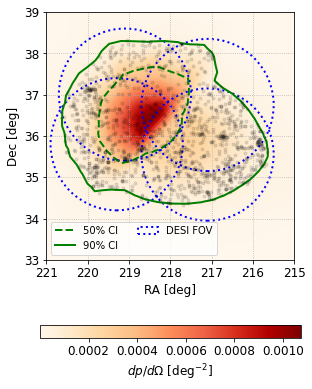

In [26]:
fig = plot_cartmap(gwfile, tile_ra=[219.1,217.1,219.3,217.1], tile_dec=[37.0,36.75,35.8,35.55],
                   targ_ra=bmerg90['RA'], targ_dec=bmerg90['DEC'],
                   angsize=3)

  44 of type COMP
 555 of type DEV
 509 of type EXP
 177 of type REX


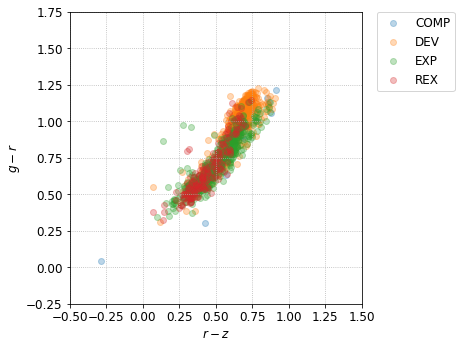

In [27]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

for _type in np.unique(bmerg90['TYPE']):
    select = bmerg90['TYPE']==_type
    print('{:4d} of type {}'.format(np.sum(select), _type))
    g_, r_, z_ = [22.5 - 2.5*np.log10(bmerg90[select]['FLUX_{}'.format(_)]) for _ in 'GRZ']

    ax.scatter(r_-z_, g_-r_, alpha=0.3, label=_type)

ax.set(xlim=(-0.5, 1.5), xlabel='$r-z$',
       ylim=(-0.25, 1.75), ylabel='$g-r$',
       aspect='equal')
ax.grid(ls=':')

ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout();

In [28]:
r_bgs = 22.5 - 2.5*np.log10(bmerg90['FLUX_R'])

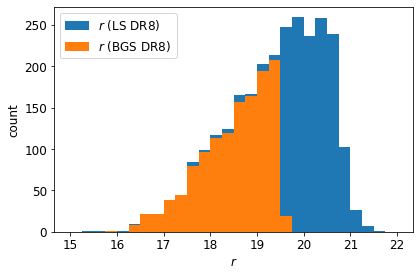

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

binsr = np.linspace(15,22,29)

ax.hist(r, bins=binsr, label='$r$ (LS DR8)')
ax.hist(r_bgs, bins=binsr, label='$r$ (BGS DR8)')
ax.set(xlabel='$r$', ylabel='count')
ax.legend(fontsize=12);